# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

INFO       Cache size for target "cython": 1122 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([0.        , 0.05553714, 0.18616409, ..., 0.34263957, 0.23894004,
        0.24489567]),
 array([ 0.        , -0.08325095,  0.03536872, ...,  0.76675788,
         0.90452414,  1.0627096 ])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
out_spikes

[array([  71.23,  122.83,  210.92,  225.54,  239.2 ,  281.24,  303.7 ,
         336.2 ,  399.15,  536.37,  597.07,  663.54,  811.95,  939.29,
         962.57,  991.39, 1009.98, 1035.9 , 1078.18, 1113.35, 1155.7 ,
        1200.08, 1270.3 , 1293.  , 1315.59, 1467.74, 1488.74, 1522.48,
        1554.55, 1571.92, 1670.46, 1705.1 , 1730.37, 1746.35, 1793.  ,
        1866.76, 1892.38, 1937.42, 1948.02, 1986.21, 2111.73, 2171.24,
        2276.79, 2418.89, 2440.3 , 2546.8 , 2584.71, 2599.82, 2662.19,
        2837.62, 2961.99, 3005.25, 3059.41, 3177.22, 3190.72, 3252.33,
        3349.37, 3418.14, 3466.01, 3521.96, 3604.86, 3638.6 , 3660.36,
        3680.88, 3691.25, 3720.41, 3829.22, 3867.82, 3904.32, 3951.12,
        3961.46, 4031.54, 4085.24, 4118.16, 4163.5 , 4199.79, 4264.13,
        4357.91, 4377.63, 4440.7 , 4477.18, 4573.26, 4614.94, 4676.63,
        4696.7 , 4713.32, 4843.36]),
 array([4.81000e+00, 2.39700e+01, 6.56500e+01, 7.03400e+01, 1.01920e+02,
        1.10710e+02, 1.17300e+02, 2.47

## Model Fitting

In [6]:
eqs = Equations(
"""
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I*k - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
taum = C / gL : second

gL: siemens (constant)
k : 1 (constant)
b : amp (constant)
""", 
# a : siemens (constant)
# VT : volt (constant)
# DeltaT : volt (constant)
# Vr : volt (constant)
# C : farad (constant)
# tauw : second (constant)
# C: farad (constant)

# gL = 60 * nS,
VT = -50.4 * mV,
DeltaT = 5 * mV,    
a = 4*nS,
Vr = -70.6*mV,
C = 171 * pF,
tauw = 144*ms,
EL = -65 * mV,

)

In [7]:
Vr = -70.6*mV
# b = 0.0805*nA


In [8]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=5*second, delta=4*ms)

In [22]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=30,
                     threshold='v>Vcut',
                     reset="v=Vr; w+=b",
                     refractory=1.41*ms,
                     param_init={'v': -65*mV},
                     )

In [23]:
result_dict, error = fitter.fit(n_rounds=4,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[59*nS, 62*nS],
#                                 a = [0, 20]*nS,
                                b = [0.08, 0.081]*nA,
#                                 VT = [-90, -10] * mV,
#                                 DeltaT = [5, 8] * mV,    
#                                 Vr = [-90, -30]*mV,
                                k = [0.1, 2],
#                                 C = [170, 200] * pF,
#                                 tauw = [0.1, 500]*ms,
                               )

Round 0: fit (8.013420314480019e-11, 1.3971547773314126, 5.982883424893523e-08) with error: 0.7013862760818906
Round 1: fit (8.016339497787433e-11, 0.38593980858785415, 5.982686227790428e-08) with error: 0.0
Round 2: fit (8.063022730627668e-11, 0.3645706604172546, 5.97054316374446e-08) with error: 0.0
Round 3: fit (8.016707722207481e-11, 0.2454552910881571, 5.997505378529122e-08) with error: 0.0


In [21]:
result_dict

{'b': 8.868491597656237e-11,
 'k': 0.2121523428894403,
 'gL': 4.604012548190668e-08}

In [12]:
error

0.0

In [13]:
1 - error

1.0

In [14]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

spike times: [array([], dtype=float64), array([], dtype=float64)]


In [15]:
print(len(out_spikes[0]))
print(len(spikes[0]))

87
0


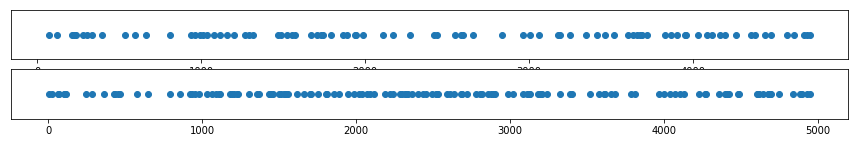

In [16]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [17]:
fits = fitter.generate(params=None, output_var='v',)

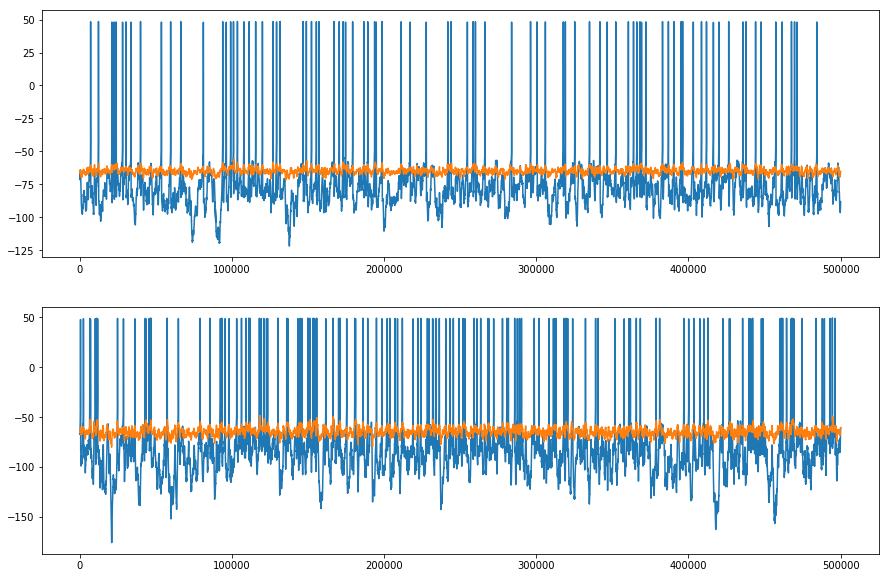

In [18]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))

ax[0].plot(voltage1);
ax[0].plot(fits[0]/mV)

ax[1].plot(voltage2);
ax[1].plot(fits[1]/mV);
